In [1]:
from smap.archiver.client import SmapClient                                                                                                                                                                                                                                                                                   
from smap.contrib import dtutil                                                                                                                                                                                                                                                                                               
import json
import scipy.io
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx
import sys
import numpy as np
import itertools
from datetime import datetime
from functools import reduce
np.set_printoptions(precision=3)
%matplotlib inline

In [2]:
# fetch data
c = SmapClient("http://new.openbms.org:8079")
print c
uuid_file = "SDH_floor_4_temperature_uuids.json"
start_time = dtutil.dt2ts(dtutil.strptime_tz("10-30-2016", "%m-%d-%Y"))
end_time = dtutil.dt2ts(dtutil.strptime_tz("11-30-2016", "%m-%d-%Y"))
                                                                                                                                                                                                                                                                                                                              
print uuid_file                                                                                                                                                                                                                                                                                                               
uuids = json.load(open(uuid_file))
data = c.data_uuid(uuids, start_time, end_time,limit=10000)

<smap.archiver.client.SmapClient instance at 0x7f5fe2244d40>
SDH_floor_4_temperature_uuids.json

downloaded 1584b from 24 urls in 0.777s (0.002MB/s download: 0.777s, parse: 0.000851s)


In [3]:
metadata_file = 'SDH_floor_4_metadata.json'
_metadata = json.load(open(metadata_file))
sensor_metadata = {}
for doc in _metadata:
    sensor_metadata[doc['uuid']] = doc
    sensor_metadata[doc['Metadata']['Instrument']['PartNumber']] = doc

# grab VAV metadata
_metadata = c.query("select * where Metadata/SourceName = 'Sutardja Dai Hall BACnet' and Path ~ '.*ROOM_TEMP' and Metadata/Extra/Vav ~ 'S4.*'")
print _metadata[0]
vav_metadata = {}
for doc in _metadata:
    vavid = doc['Metadata']['Extra']['Vav']
    room = doc['Description'].split(' ')[0]
    uuid = doc['uuid']
    insert = {
            'VAV': vavid,
            'Room': room,
            'uuid': uuid,
        }
    vav_metadata[vavid] = insert
    vav_metadata[room] = insert
    vav_metadata[uuid] = insert

def uuid_to_ketiid(uuid):
    return sensor_metadata[uuid]['Metadata']['Instrument']['PartNumber']
def ketiid_to_vavid(ketiid):
    vav = sensor_metadata[ketiid]['Metadata']['Extra']['VAV']
    print ketiid, vav
    

{'Path': '/Siemens/SDH.PXCM-11/SDH/S4-19/ROOM_TEMP', 'uuid': 'a7aad37c-6dd8-5252-8443-65471582f8e9', 'Metadata': {'SourceName': 'Sutardja Dai Hall BACnet', 'Location': {'Building': 'Sutardja Dai Hall', 'Campus': 'UCB'}, 'PointName': 'SDH.S4-19:ROOM TEMP', 'Extra': {'Type': 'room temperature', 'Vav': 'S4-19'}}, 'Properties': {'Timezone': 'America/Los_Angeles', 'UnitofMeasure': 'F', 'ReadingType': 'double'}, 'Description': '477 WOMENS BATH'}


In [4]:
# build data frames
temperatures = {}
for uuid, datas in zip(uuids, data):             
    if len(datas) == 0: continue
    df = pd.DataFrame.from_records(datas)
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ms'))
    df = df.resample('30min').mean()
    df.columns = [int(uuid_to_ketiid(uuid))]
    temperatures[uuid] = df
    print uuid, df.count()

0bfbd947-40a2-5454-a352-1375790c604d 1707    799
dtype: int64
19dac044-e8ae-5ed4-a789-a46d2cd9d375 1709    1335
dtype: int64
1f17fd93-8009-5153-926f-54395c421d93 1715    27
dtype: int64
27e71c02-6a7c-5d29-9d7e-3b437f9f6c46 1706    1025
dtype: int64
2a756197-f1b3-56eb-ab87-a61111bdd80b 1624    87
dtype: int64
2e22715f-9d3e-5c5d-b90c-8b6226e29cca 1712    1335
dtype: int64
31e75b66-41bf-518d-a144-f3e144f396e5 1713    1335
dtype: int64
3d4496b0-63e8-5d88-890a-cbce6f1202a6 1716    1335
dtype: int64
41d4673c-0926-5c58-91a3-7c440ed6962c 1631    311
dtype: int64
4fa00ebf-6387-5183-b987-2b54e1031ec4 1627    717
dtype: int64
6b0b7685-fd48-5d27-840c-d730ed6681d7 1628    115
dtype: int64
6d03bfef-f70e-5c58-953c-d9b52c41835c 1632    498
dtype: int64
9165f400-355d-506a-8afa-421273d02010 1702    69
dtype: int64
a988771e-b6c8-5b2e-9c23-ad88e5efe3e6 1630    63
dtype: int64
c796ac06-e7fc-5127-b105-ebc3101a43be 1622    1335
dtype: int64
d0184967-52c2-5c3f-ad90-6e49f10faa7e 1629    1335
dtype: int64


1434


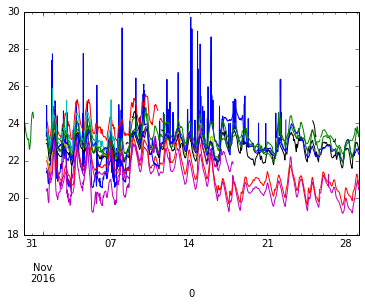

In [5]:
# merge all timeseries into the same data frame
dfs = temperatures.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

32


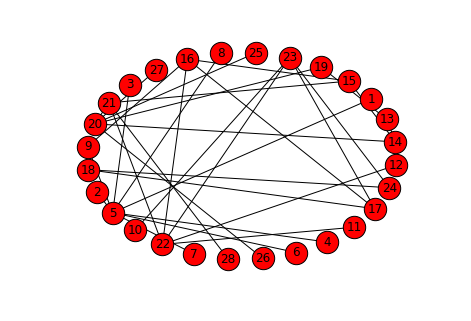

In [6]:
nodes = range(1,28+1)
edges = [
    (1,5),
    (2,5),
    (3,5),
    (4,5),
    (5,6),
    (5,7),
    (5,8),
    (5,9),
    (9,16),
    (13,14),
    (14,15),
    (15,16),
    (16,17),
    (17,18),
    (13,19),
    (19,20),
    (14,20),
    (20,21),
    (15,21),
    (21,22),
    (16,22),
    (22,23),
    (17,23),
    (23,24),
    (18,24),
    (20,25),
    (20,26),
    (20,27),
    (21,28),
    (22,12),
    (22,11),
    (23,10),
]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, iterations=500, k=2.0, scale=10.0)
#pos = dict((n,(n, n%10+1)) for n in G.nodes())
nx.draw(G,pos,node_size=500,with_labels=True)
nodes = G.nodes()
minNode = min(nodes)
edges = G.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('sdh_small_edges_30m.mat',{'edges': e})

In [7]:
keti_mapping = {
    1712: 1,
    1713: 2,
    1715: 3,
    1716: 4,
    1632: 14,
    1631: 15,
    1630: 18,
    1622: 20,
    1624: 21,
    1627: 22,
    1628: 23,
    1629: 24,
    1707: 26,
    1702: 11,
    1709: 10,
}
current.columns

Int64Index([1706, 1702, 1632, 1630, 1712, 1627, 1629, 1628, 1716, 1713, 1631,
            1707, 1715, 1624, 1709, 1622],
           dtype='int64')

In [8]:
# want to rename the data columns in terms of which node in the graph they are
# also need data for all of the nodes: "easiest" way is to take average of temperatures of nearby nodes
# This is what gets put in 'sdh_idea1.csv'

# First take our empirical data and replace the keti ids with the node ids
current = current[keti_mapping.keys()].rename(columns=keti_mapping)
# Now we need to "fill" the graph: For each node for which we have original data (make this list at the beginning),
# we do a breadth-first traversal through the tree. At each node we visit, its temperature becomes the average of
# its neighboring nodes; if the node's neighbors do not have any values, then we just use the value we are
# propagating from; if the node already has a value (that's not an empirical value), then its new value is the
# average of its new temperature and its neighbors (using the propagating value if neighbors have no values)
empirical_nodes = current.columns
print empirical_nodes
data_row = current.iloc[0]
result = pd.DataFrame()
rownum = 0
t = datetime.now()
for row in current.iterrows():
    rownum += 1
    for en in empirical_nodes:
        data_row = row[1]
        if pd.isnull(data_row[en]):
            #print en,'has no data'
            continue
        propagate_point = data_row[en]
        bfs_edges = nx.algorithms.traversal.bfs_edges(G, en)
        # the 2nd item (index 1) of each edge is the next node
        bfs_nodes = [x[1] for x in bfs_edges if x[1] not in empirical_nodes or pd.isnull(data_row[x[1]])]
        for node in bfs_nodes:
            neighbors = G.neighbors(node)
            # get data from neighbors
            datas = [data_row.get(n, propagate_point) for n in neighbors]
            # get data from ourself
            datas.append(data_row.get(node, propagate_point))
            # filter out nans
            datas = filter(lambda x: not pd.isnull(x), datas)
            data_row[node] = np.mean(datas)
    if rownum % 1000 == 0:
        print rownum, len(current), (datetime.now()-t).total_seconds()
        t = datetime.now()
    result = result.append(data_row)

Int64Index([20, 21, 22, 23, 24, 18, 15, 14, 11, 26, 10, 1, 2, 3, 4], dtype='int64')
1000 1434 26.7148


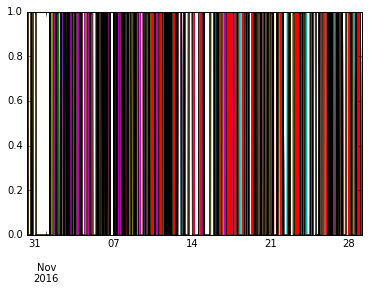

In [9]:
# compute whether or not temperature going up or not
df = result.copy()
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = 0
diffs = diffs.fillna(0)
diffs.plot(legend=False)
diffs.tail()
diffs.to_csv("sdh_small_data_30m.csv",sep="\t",header=False,index=False)